In [11]:
from pynqOverlay import *
from pynqOverlayDriver import *
#viene richiamata la classe per la gestione del filtro e dell'hdmi
po = pynqOverlay()

hdmi_in = po.ol.video.hdmi_in
hdmi_out = po.ol.video.hdmi_out

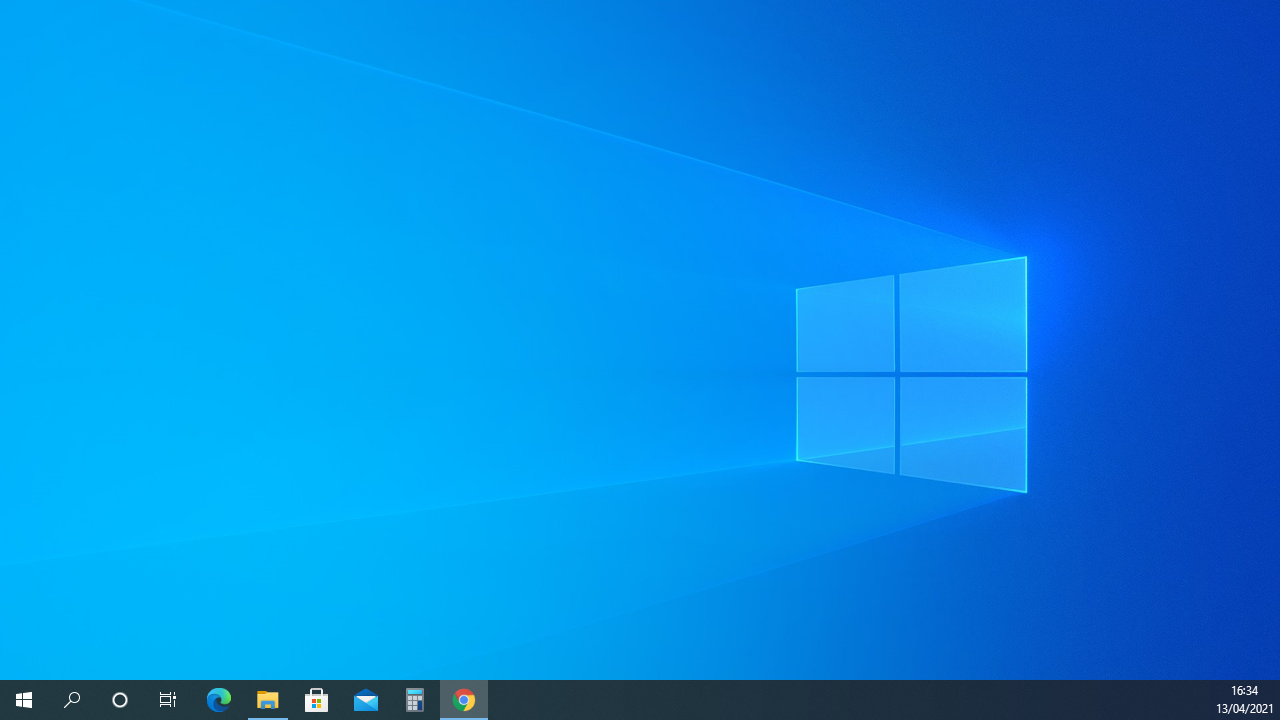

In [12]:
import PIL.Image
import numpy as np
from IPython.display import display
from pynq import allocate


#configurazione della modalità dei canali hdmi in RGB
hdmi_in.configure(PIXEL_RGB)
hdmi_out.configure(hdmi_in.mode,PIXEL_RGB)


#start dei canali hdmi
hdmi_in.start()
hdmi_out.start()

hdmi_in.tie(hdmi_out)


#cattura del frame 
frame = hdmi_in.readframe()

original_image = PIL.Image.fromarray(frame)
display(original_image)

In [13]:
#l'immagine viene convertita in scala di grigi per un filtraggio migliore

img=original_image.convert('L')
img.save("imagegray.png")

pic_width, pic_height = img.size
input_array = np.array(img)

In [14]:
#creazione dei buffer di input e output da passare al DMA tramite il filtro

image_buffer  =allocate(shape=(pic_height, pic_width), dtype=np.uint8, cacheable=True)
return_buffer =allocate(shape=(pic_height, pic_width), dtype=np.uint8, cacheable=True)

np.copyto(image_buffer,input_array)

In [15]:
#calcolo degli FPS usando pynqOverlay

import time

iterations = 10

start = time.time()
for i in range(iterations):           
    po.Sobel(image_buffer,-1,1,0,dst=return_buffer)    

In [16]:
end = time.time()
print("Frame per secondo usando pynqOverlay con CMA:  " + str(iterations / (end - start)))

Frame per secondo usando pynqOverlay con CMA:  13.14163107341234


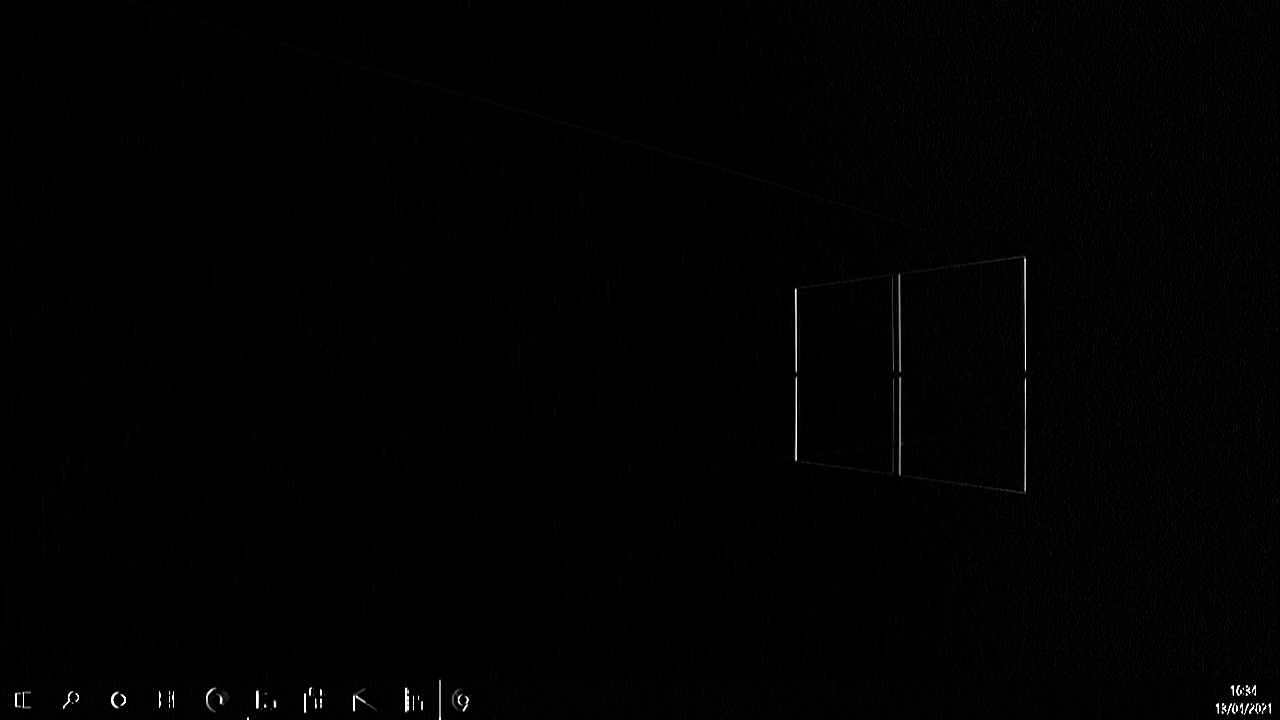

In [17]:
imgresult = PIL.Image.fromarray(return_buffer)
display(imgresult)

In [18]:
#calcolo degli FPS usando cv2 

import cv2

iterations = 10
start = time.time()

for i in range(iterations):           
    cv2.Sobel(image_buffer,-1,1,0,dst=return_buffer)      

In [19]:
end = time.time()
print("Frame per secondo usando cv2:  " + str(iterations / (end - start)))

Frame per secondo usando cv2:  4.3820942677501655


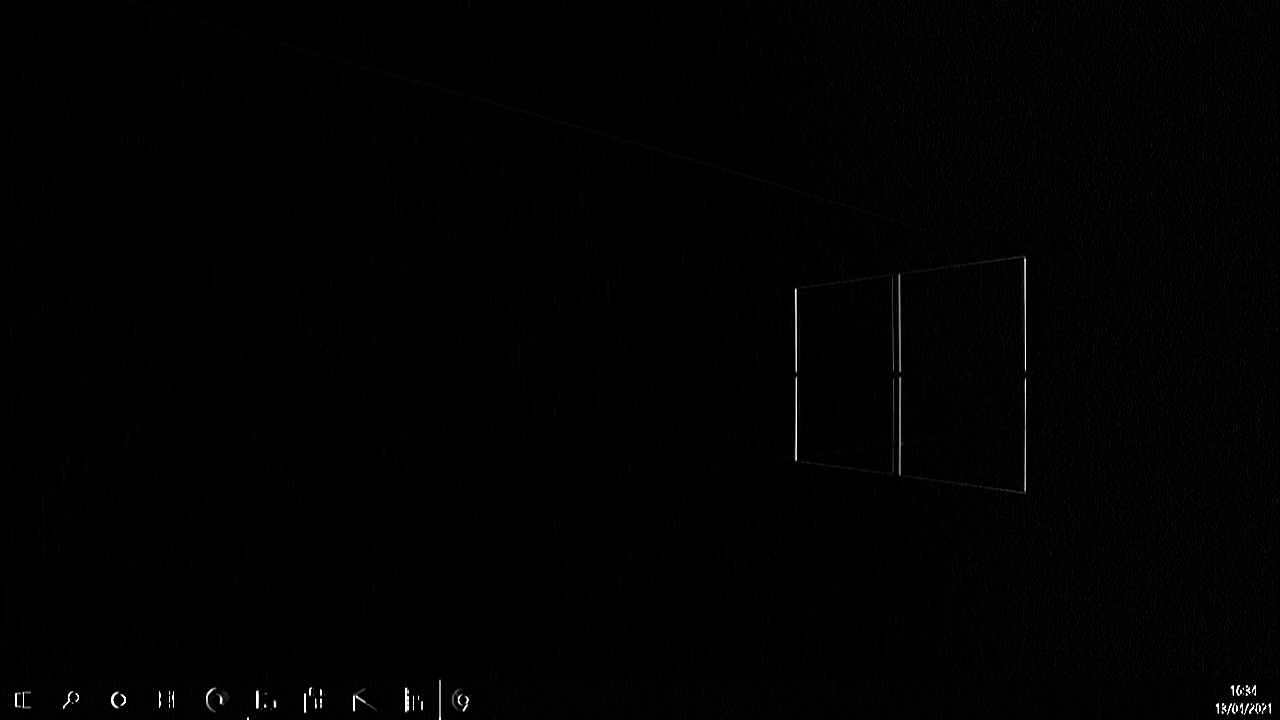

In [20]:
imgresult = PIL.Image.fromarray(return_buffer)
display(imgresult)

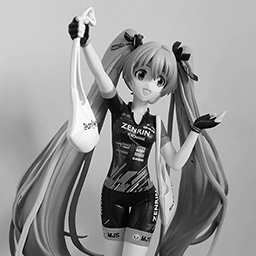

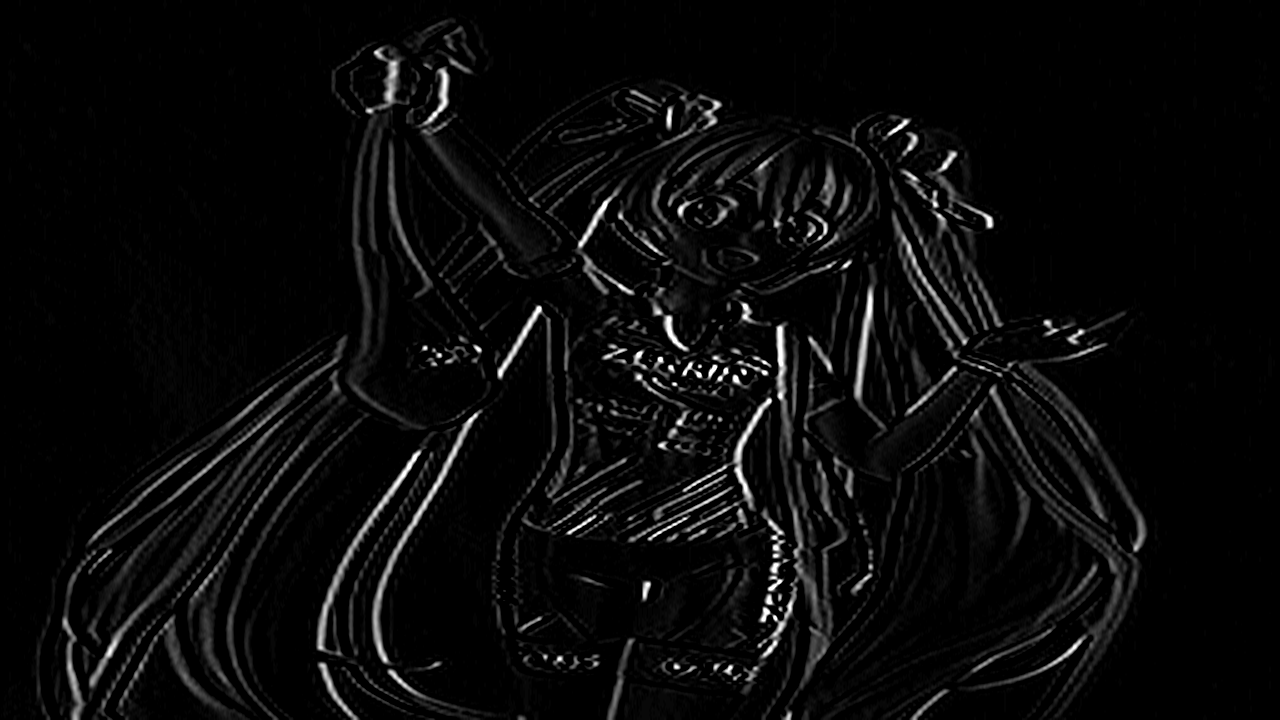

In [21]:
#viene aperta la foto 5.bmp e ridimensionata con le dimensioni dello schermo su cui si vuoi streammare

img=PIL.Image.open("5.bmp")
display(img)

img = img.resize((1280,720), PIL.Image.ANTIALIAS)
img_stream=np.asarray(img)

#dopo averla resa array d tuple si crea un nuovo frame e gli viene assegnata l'immagine con il filtrto applicato

outframe = hdmi_out.newframe()
po.Sobel(img_stream,-1,1,0,dst=outframe)
hdmi_out.writeframe(outframe)

imgresult = PIL.Image.fromarray(outframe)
display(imgresult)


In [22]:
#chiusura dei canali hdmi e dei buffer creati all'inizio del processo

hdmi_out.stop()
hdmi_in.stop()

del hdmi_in, hdmi_out

po.close()